In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime 
import math
import sys
sys.path.append('../')
#
from structures.ratecurves import *
from instruments.simpleswap import *
from models.hullwhitesimple import *
from engines.gaussian1d import *



## Simple swap price and rate sensy

In [2]:
rc_pillars = [0.25, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0]
rc_rates = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
rate_curve = RateCurveSimple(rc_pillars, rc_rates)
## swap
irs_schedule = ['2024-10-11', '2025-10-11', '2026-10-11', '2027-10-11', '2028-10-11', '2029-10-11']
irs_schedule = [datetime.strptime(date, '%Y-%m-%d') for date in irs_schedule]
irs = SwapSimple(100000.0, 0.04, False, irs_schedule) #receiver

with tf.GradientTape() as tape:
    pv = irs.price(datetime.today(), rate_curve)
    
sensy_zero = tape.gradient(pv, rate_curve.rates)

## Hull and White simulation

In [3]:
mean_rev = 0.02
sigma = 0.045
hw = HullWhiteProcess(mean_rev, sigma, market_curve=rate_curve)


last_grid_time = 20
time_steps = 50
hw_kernel = GaussianRateKernel1D(hw)
r_tensor, zb_tensor, grid = hw_kernel.rate_tensor(1000, last_grid_time, time_steps)

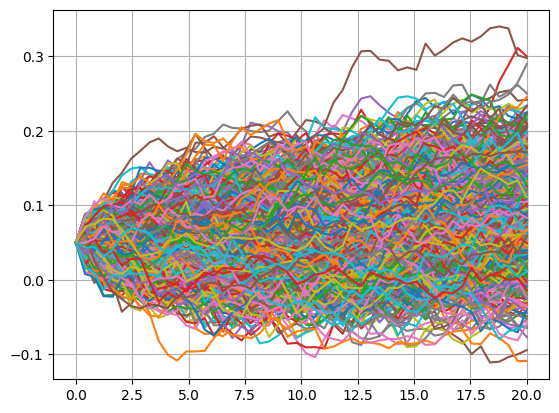

In [4]:
plt.plot(grid, r_tensor)
plt.grid()
plt.show()

## Test Pricing CPU

In [6]:
# Reshape the tensor
reshaped_tensor = tf.transpose(zb_tensor, perm=[1, 2, 0])  # Transpose the dimensions
reshaped_tensor = tf.reshape(reshaped_tensor, shape=(8, 1000, 49))
rate_curve_tensor = RateCurveSimple(rc_pillars, reshaped_tensor)

In [7]:
def portfolio_cube_std(portfolio):
    return [deal.price(datetime.today(), rate_curve_tensor) for deal in portfolio]

@tf.function
def portfolio_cube(portfolio):
    return [deal.price(datetime.today(), rate_curve_tensor) for deal in portfolio]

@tf.function(jit_compile = True)
def portfolio_cube_xla(portfolio):
    return [deal.price(datetime.today(), rate_curve_tensor) for deal in portfolio]


In [8]:
irs_schedule = ['2024-10-11', '2025-10-11', '2026-10-11', '2027-10-11', '2028-10-11', '2029-10-11']
irs_schedule = [datetime.strptime(date, '%Y-%m-%d') for date in irs_schedule]
irs = SwapSimple(100000.0, 0.04, False, irs_schedule) #receiver
irs_list = [irs]*1000

In [9]:
cube0 = portfolio_cube_std(irs_list)

In [10]:
cube0[0]

<tf.Tensor: shape=(1000, 49), dtype=float64, numpy=
array([[-38473.27814882, -38232.93522582, -38025.64352524, ...,
        -37339.13832256, -36982.61013029, -35881.88903691],
       [-38504.6320532 , -38483.25898545, -38472.02107217, ...,
        -37958.80588324, -37787.4269057 , -37701.8810975 ],
       [-38277.48671727, -37750.82470191, -37930.19771781, ...,
        -35530.17052922, -36246.89557771, -35421.92458276],
       ...,
       [-38489.80673865, -38225.47586492, -37879.34531712, ...,
        -35322.97295358, -34263.60077776, -34370.75982308],
       [-38338.77162248, -38259.10118918, -38113.11527284, ...,
        -35708.87880913, -35381.86365576, -36633.21420867],
       [-38503.79677002, -38495.93569901, -38440.35990447, ...,
        -37939.32269245, -38014.89478932, -37898.17230065]])>